# Import and download

In [ ]:
pip install keras-self-attention


  Preparing metadata (setup.py) ... done
  Created wheel for keras-self-attention: filename=keras_self_attention-0.51.0-py3-none-any.whl size=18895 sha256=789b5ba718f3a155f92ba529f694066cf31a4dae9e96323b30985897df2a1122
  Stored in directory: /root/.cache/pip/wheels/b8/f7/24/607b483144fb9c47b4ba2c5fba6b68e54aeee2d5bf6c05302e
Successfully built keras-self-attention


In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from nltk.stem import WordNetLemmatizer
import keras
import nltk
from keras.layers import Embedding, Flatten, SimpleRNN, Dense,LSTM,Dropout,Attention,Input, Concatenate,Bidirectional
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from tensorflow.keras import backend as K
from keras_self_attention import SeqSelfAttention
from nltk.corpus import stopwords
from keras.regularizers import l2

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

stopword=set(stopwords.words('english'))
stemmer=nltk.SnowballStemmer('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Read the Data

In [ ]:
data=pd.read_csv("labeled_data.csv")

In [ ]:
dataplus=pd.read_csv("train.csv")

In [ ]:
data_class0 = dataplus[dataplus['label'] == 0]
data_class0.rename(columns={'label': 'class'}, inplace=True)

<ipython-input-7-ea1e835f4d19>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_class0.rename(columns={'label': 'class'}, inplace=True)


In [ ]:
data_class0 = data_class0.head(10000)
data_class0.shape

(10000, 3)

In [ ]:
data_class0.head()

,id,class,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


In [ ]:
data['class'].unique

<bound method Series.unique of 0        2
1        1
2        1
3        1
4        1
        ..
24778    1
24779    2
24780    1
24781    1
24782    2
Name: class, Length: 24783, dtype: int64>

# Droup Columns

In [ ]:
columns_to_drop = ['count','hate_speech','offensive_language','neither']
data.drop(columns_to_drop, axis=1, inplace=True)

In [ ]:
data.drop('Unnamed: 0', axis=1, inplace=True)

In [ ]:
data_class0.drop('id', axis=1, inplace=True)

In [ ]:
data

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...
...,...,...
24778,1,you's a muthaf***in lie &#8220;@LifeAsKing: @2...
24779,2,"you've gone and broke the wrong heart baby, an..."
24780,1,young buck wanna eat!!.. dat nigguh like I ain...
24781,1,youu got wild bitches tellin you lies


# Data Distribution
concatenate class 1 and 0

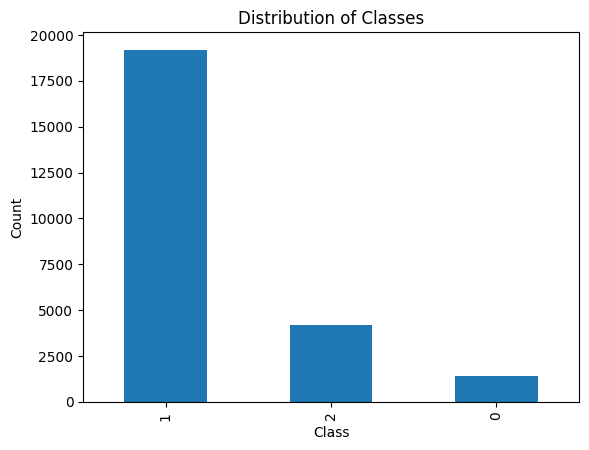

In [ ]:
import matplotlib.pyplot as plt

data['class'].value_counts().plot(kind='bar')
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [ ]:
data.loc[data['class'] == 0, 'class'] = 1 # we combine class 0 and class 1

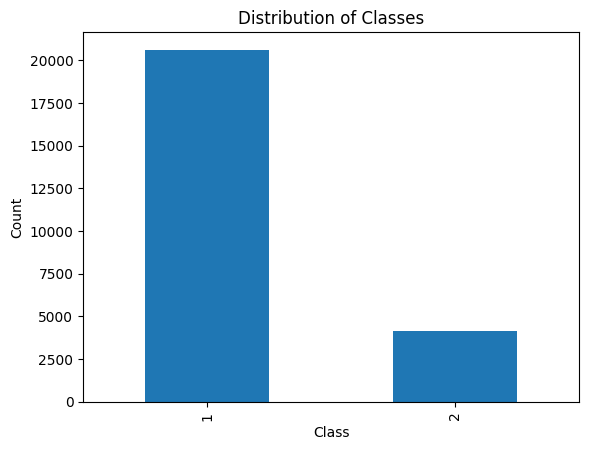

In [ ]:
import matplotlib.pyplot as plt

data['class'].value_counts().plot(kind='bar')
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

In [ ]:
data["class"].replace({2: 0}, inplace=True)

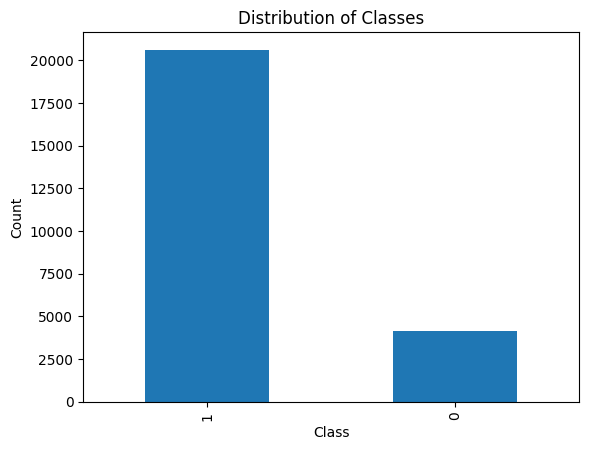

In [ ]:
import matplotlib.pyplot as plt

data['class'].value_counts().plot(kind='bar')
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Add Data
increase class 0 that is no hate

In [ ]:
frame=[data,data_class0]
data = pd.concat(frame)

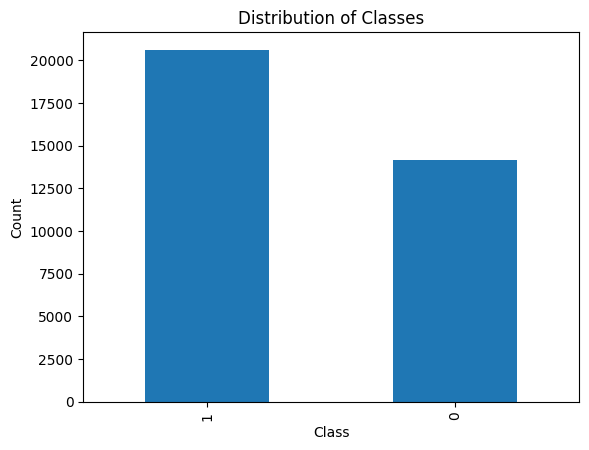

In [ ]:
import matplotlib.pyplot as plt

data['class'].value_counts().plot(kind='bar')
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Before cleaning

In [ ]:
data.loc[22478,'tweet']

'Was finna slit my eyebrows up in the shop but nahhhhhh.\n.\n.\n.\n.\n.\n.\n.\n.\n.\n.\n.\n.\n.\n.\n.\n.\n.\n.\n.\n.\n.\n.\n.\n.\n.\n.\n.\n.\n\n.\n.\n.\n.\n.\n.\n.\n.\n.\n.\n.\n.\n.'

In [ ]:
data.loc[9,'tweet']

9    " @rhythmixx_ :hobbies include: fighting Maria...
9     @user @user welcome here !  i'm   it's so #gr...
Name: tweet, dtype: object

# Data Cleaning

In [ ]:
def clean (text):
  text = str(text).lower()
  #text = re.sub(r"[A-Za-z0-9]", "", text)
  text = re.sub(r'@\w+', '', text)
  text = re.sub(r'\n', ' ', text)
  text=re.sub(r'[^\w\s]', '', text)
  text=re.sub(r'\d+', '', text)
  text = re.sub(r'(\d+;)+\d+', '', text)
  text = re.sub(r"(rt)","",text)
  text = re.sub(r"@.+:","",text)
  text = re.sub(r"@|#|_","", text)
  text = re.sub(r"://","", text)
  text = re.sub(r"//","",text)
  text = re.sub(r"\.{2,}","", text)
  text = re.sub(r"\./","", text)
  text = re.sub(r"\"\"","", text)
  text = re.sub(r"\s\"","", text)
  text = re.sub(r"\!{2,}","", text)
  text = re.sub(r"\?{2,}","", text)
  text = re.sub(r"\.{2,}","", text)
  text = re.sub(r"\|","", text)
  text = re.sub(r"\\n","", text)
  text = re.sub(r"\%","", text)
  text = re.sub(r":","", text)
  text = re.sub(r"~","", text)
  text = re.sub(r"&","", text)
  text = re.sub(r"\.|\!|\?|\,|\-|\_|\/|\)|\(|\>>","", text)
  text = re.sub(r'\s+', ' ', text)
  text = [word for word in text.split(' ') if word not in stopword]
  text=" ".join(text)
  text = [stemmer. stem(word) for word in text. split(' ')]
  text=" ".join(text)
  # text = spell(text)
  return text

data["tweet"]= data["tweet"].apply(clean)

In [ ]:
def remove_emoji(text):
  emoji_pattern = re.compile("["
                                  u"\U0001F600-\U0001F64F"
                                  u"\U0001F300-\U0001F5FF"
                                  u"\U0001F680-\U0001F6FF"
                                  u"\U0001F1E0-\U0001F1FF"
                                  u"\U00002702-\U000027B0"
                                  u"\U000024C2-\U0001F251"
                                  "]+", flags=re.UNICODE)
  text= emoji_pattern.sub(r'',text)
  return text

data["tweet"]= data["tweet"].apply(remove_emoji)

# After Cleaning

In [ ]:
data.loc[9,'tweet']

9     hobbi includ fight mariam bitch
9                       welcom im gr 
Name: tweet, dtype: object

In [ ]:
data.loc[22478,'tweet']

'finna slit eyebrow shop nahhhhhh '

# Get text information
Like max_lenght ,Total words,unique words

In [ ]:
data["length_input"]=data["tweet"].apply(lambda text:len(text.split(" ")))


In [ ]:
max_input_length=np.array(data["length_input"].to_list()).max()
max_input_length

28

In [ ]:
Totalsum=sum(data["length_input"])
Totalsum

301462

In [ ]:
# Getting the Unique word
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['tweet'])


vocab_size_unique = len(tokenizer.word_index) + 1


vocab_size_unique

31585

# split data to train, test , and validation

In [ ]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

train_data, validation_data = train_test_split(train_data, test_size=0.2, random_state=42)

x_train, y_train = train_data['tweet'], train_data['class']
x_valid, y_valid = validation_data['tweet'], validation_data['class']
x_test, y_test = test_data['tweet'], test_data['class']


# Tokenizer

In [ ]:
vocab_size=vocab_size_unique
embd_size=100
max_sew_lenght=max_input_length
tokenizer=Tokenizer(num_words= vocab_size,oov_token='[oov]')
#X_resampled, y_resampled
tokenizer.fit_on_texts(x_train)
x_train_vect=tokenizer.texts_to_sequences(x_train)

x_test_vect=tokenizer.texts_to_sequences(x_test)
x_vaid_vect=tokenizer.texts_to_sequences(x_valid)

x_train_vect

[[331, 1775, 239, 140],
 [1480, 134],
 [935, 4440, 2],
 [446, 2, 3219, 674, 82, 1108],
 [361,
  235,
  499,
  828,
  26,
  269,
  2037,
  43,
  2590,
  1290,
  683,
  805,
  3685,
  2591,
  1036,
  967,
  8086],
 [4441, 17, 3220, 2592, 50, 19],
 [5623, 7, 8087, 2, 213, 853, 8088, 780, 8089],
 [71, 258, 205, 1412, 532, 95, 34, 2854, 2203, 2383, 2, 2203],
 [1890, 61, 2, 4],
 [697, 2204, 8090, 417, 7],
 [187, 2, 245, 316],
 [164, 39, 829, 2384, 12, 76, 7, 12, 24, 1481, 270, 598],
 [731, 70, 608, 3221, 490, 251, 608],
 [1567, 3, 1568, 8091],
 [44, 10, 2593, 82, 1776, 2, 121, 118, 15, 150, 10, 8092],
 [8093, 385, 172, 1777, 401, 3222, 8094, 385],
 [2, 27, 520, 1891, 8095],
 [8096, 24, 16, 270, 5624, 393],
 [362, 872],
 [7, 10, 1000],
 [8097, 2, 9, 22, 81, 3686, 873, 3223, 1291, 8098],
 [9, 26, 48, 2, 122, 1778],
 [698, 7],
 [454, 563, 394, 151, 481, 4442],
 [282, 18, 40, 152, 3, 288, 12, 9, 91, 264, 51, 106, 15, 8099],
 [252, 11, 12, 47, 12, 31, 363, 247, 126],
 [34, 24, 3687, 128, 2385, 7,

# Padding

In [ ]:
from keras.utils import pad_sequences

x_train_vect=pad_sequences(x_train_vect,maxlen=max_sew_lenght,padding='post')

x_test_vect=pad_sequences(x_test_vect,maxlen=max_sew_lenght,padding='post')
x_valid_vect=pad_sequences(x_vaid_vect,maxlen=max_sew_lenght,padding='post')


x_train_vect[100]

array([  34,   39,   24,   39,  187,    2,  159, 8140,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0], dtype=int32)

# Model 1

In [ ]:
from pickle import EMPTY_DICT
model=Sequential(
    [
        Embedding(input_dim= vocab_size, output_dim= embd_size, input_length=max_sew_lenght),
        #SimpleRNN(units=30,return_sequences=True),
        LSTM(units=30, activation='tanh'),
        Dense(5,activation='relu'),
        #Dense(5,activation='relu'),
        #Dense(5,activation='relu'),
        Dense(3,activation='softmax'),
    ]
)

# Model 2

In [ ]:
model = Sequential()
model.add(Embedding(input_dim= vocab_size, output_dim= embd_size, input_length=max_sew_lenght))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(units=embd_size, activation='relu',return_sequences=True)))
model.add(Dropout(0.5))
model.add(SeqSelfAttention(attention_activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(1,activation='sigmoid', kernel_regularizer=l2(0.01)))


# Model 3

In [ ]:
import tensorflow as tf
input_layer = Input(shape=(max_sew_lenght,))

embedding_layer = Embedding(input_dim=vocab_size, output_dim=embd_size, input_length=max_sew_lenght)(input_layer)

lstm_layer = LSTM(units=30, activation='tanh', return_sequences=True)(embedding_layer)

attention = Attention()([lstm_layer, lstm_layer])

weighted_sum = K.sum(attention * lstm_layer, axis=1)

dense_layer = Dense(5, activation='relu')(weighted_sum)

output_layer = Dense(3, activation='softmax')(dense_layer)

model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28)]                 0         []                            
                                                                                                  
 embedding_2 (Embedding)     (None, 28, 100)              3158500   ['input_1[0][0]']             
                                                                                                  
 lstm_2 (LSTM)               (None, 28, 30)               15720     ['embedding_2[0][0]']         
                                                                                                  
 attention (Attention)       (None, 28, 30)               0         ['lstm_2[0][0]',              
                                                                     'lstm_2[0][0]']          

In [ ]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 28, 100)           3158500   
                                                                 
 dropout_3 (Dropout)         (None, 28, 100)           0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 28, 200)           160800    
 onal)                                                           
                                                                 
 dropout_4 (Dropout)         (None, 28, 200)           0         
                                                                 
 seq_self_attention_1 (SeqS  (None, 28, 200)           12865     
 elfAttention)                                                   
                                                                 
 dropout_5 (Dropout)         (None, 28, 200)          

# EarlyStopping
For overfitting after 3 epochs if no improvement stop and take the Best Weights

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)


In [ ]:
from re import escape

history=model.fit(x_train_vect,y_train,validation_data=[x_valid_vect,y_valid],epochs=10, callbacks=[early_stopping])


Epoch 1/10
696/696 [==============================] - 92s 125ms/step - loss: 0.3361 - accuracy: 0.9106 - val_loss: 0.1430 - val_accuracy: 0.9580
Epoch 2/10
696/696 [==============================] - 90s 129ms/step - loss: 0.1232 - accuracy: 0.9677 - val_loss: 0.1336 - val_accuracy: 0.9610
Epoch 3/10
696/696 [==============================] - 89s 128ms/step - loss: 0.0820 - accuracy: 0.9778 - val_loss: 0.1471 - val_accuracy: 0.9540
Epoch 4/10
696/696 [==============================] - 87s 124ms/step - loss: 0.0583 - accuracy: 0.9852 - val_loss: 0.1659 - val_accuracy: 0.9477
Epoch 5/10
696/696 [==============================] - 90s 129ms/step - loss: 0.0443 - accuracy: 0.9895 - val_loss: 0.2038 - val_accuracy: 0.9447


(0.0, 1.0)

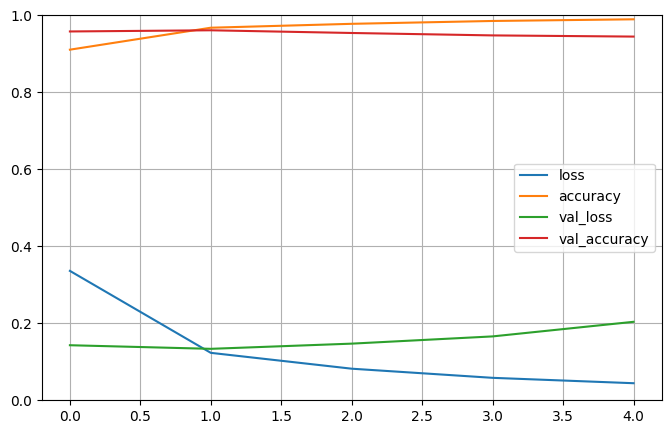

In [ ]:
import pandas as pd
plt=pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.set_ylim(0, 1)

In [ ]:
loss, accuracy = model.evaluate(x_test_vect, y_test)

218/218 [==============================] - 5s 23ms/step - loss: 0.1309 - accuracy: 0.9622


In [ ]:
lstm_prediction2=model.predict(x_test_vect)
print(lstm_prediction2[0:5])
res2=[]
for prediction in lstm_prediction2:
    if prediction[0]<0.45:
        res2.append(0)
    else:
        res2.append(1)

218/218 [==============================] - 5s 18ms/step
[[0.9998791 ]
 [0.99946105]
 [0.26004046]
 [0.00578385]
 [0.95297563]]


In [ ]:
print("Please Enter a sentence:")
text = input('')
text = clean(text)
text = remove_emoji(text)

tokenizer = Tokenizer()
tokenizer.fit_on_texts([text])

text_vect = tokenizer.texts_to_sequences([text])
text_pad = pad_sequences(text_vect, maxlen=max_sew_lenght, padding='post')
print("Processed Text:", text_pad)
prediction = model.predict(text_pad)

binary_prediction = (prediction < 0.5).astype(int)


if binary_prediction[0] == 0:
    print("Prediction: Not Hate")
else:
    print("Prediction: Hate")

Please Enter a sentence:
I hate you
Processed Text: [[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
1/1 [==============================] - 0s 33ms/step
Prediction: Hate


In [ ]:
prediction

array([[0.9930715]], dtype=float32)

In [ ]:
(prediction > 0.5)

array([[ True]])